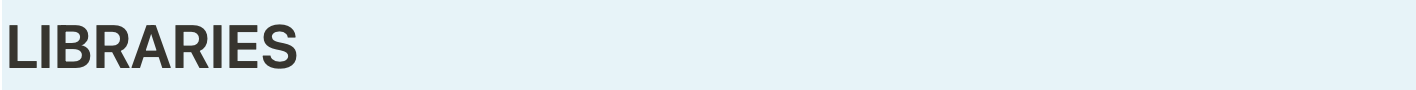

In [2]:
import os, re, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy import ndimage
from skimage.transform import resize, rescale
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation,
    Conv2DTranspose, UpSampling2D, add, BatchNormalization,
    Concatenate, LeakyReLU
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import layers as L
from tensorflow.keras.utils import plot_model
from keras.saving import register_keras_serializable

# Set random seed for reproducibility
np.random.seed(0)

# Check TensorFlow version
print(tf.__version__)


2.16.2


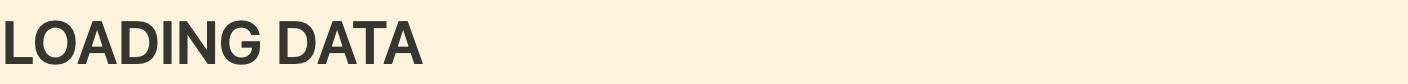

In [3]:
# === Configuration ===
LR_SIZE    = 256    # model input
HR_SIZE    = 512    # model target
BATCH_SIZE = 2      # start here; try 16 if you have headroom
AUTOTUNE   = tf.data.AUTOTUNE

base_dir        = '/Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/data/raw/div2k'
train_hr_dir    = os.path.join(base_dir, 'DIV2K_train_HR')
valid_hr_dir    = os.path.join(base_dir, 'DIV2K_valid_HR')

# human-friendly sort, if you really need it on filenames
def sorted_alphanumeric(file_list):
    convert    = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum   = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(file_list, key=alphanum)

# 1) gather all the HR filepaths
train_hr_paths = sorted_alphanumeric(glob.glob(os.path.join(train_hr_dir, '*.png')))
valid_hr_paths = sorted_alphanumeric(glob.glob(os.path.join(valid_hr_dir, '*.png')))

# 2) helper to load and decode an image from disk → float32 [0,1]
def load_image(path):
    data = tf.io.read_file(path)
    img  = tf.image.decode_png(data, channels=3)
    img  = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img

# 3) on-the-fly preprocessing + augmentation
def preprocess_and_augment(hr):
    # a) random crop an HR patch
    hr = tf.image.random_crop(hr, size=[HR_SIZE, HR_SIZE, 3])
    # b) create the LR patch by bicubic down-sampling
    lr = tf.image.resize(hr, [LR_SIZE, LR_SIZE], method='bicubic')
    # c) random flips
    if tf.random.uniform(()) > 0.5:
        lr = tf.image.flip_left_right(lr);  hr = tf.image.flip_left_right(hr)
    if tf.random.uniform(()) > 0.5:
        lr = tf.image.flip_up_down(lr);     hr = tf.image.flip_up_down(hr)
    # d) random 90° rotations
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    lr = tf.image.rot90(lr, k);  hr = tf.image.rot90(hr, k)
    # e) simple color jitter on the LR 
    lr = tf.image.random_brightness(lr, max_delta=0.1)
    lr = tf.image.random_contrast(lr, lower=0.9, upper=1.1)
    return lr, hr

# 4) build the training Dataset
train_ds = (
    tf.data.Dataset
      .from_tensor_slices(train_hr_paths)
      .shuffle(len(train_hr_paths), seed=42)
      .map(lambda p: load_image(p),               num_parallel_calls=AUTOTUNE)
      .map(preprocess_and_augment,                num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# 5) build the validation Dataset (no augment, just center-crop/resize)
def preprocess_valid(hr):
    hr = tf.image.resize(hr, [HR_SIZE, HR_SIZE])
    lr = tf.image.resize(hr, [LR_SIZE, LR_SIZE], method='bicubic')
    return lr, hr

valid_ds = (
    tf.data.Dataset
      .from_tensor_slices(valid_hr_paths)
      .map(lambda p: load_image(p),   num_parallel_calls=AUTOTUNE)
      .map(preprocess_valid,          num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# 6) sanity-check shapes
for lr_batch, hr_batch in train_ds.take(1):
    print(" LR batch:", lr_batch.shape, " HR batch:", hr_batch.shape)


2025-09-17 17:22:31.313534: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-17 17:22:31.313771: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-17 17:22:31.313788: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-09-17 17:22:31.314005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-17 17:22:31.314027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 LR batch: (2, 256, 256, 3)  HR batch: (2, 512, 512, 3)


2025-09-17 17:22:32.009324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# ARCITECTURE OF MODEL 


In [3]:
# === Prereqs (keep once in your file) ===
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

# ============================ Custom Resize Layers ========================== #



# ============================== Custom Layers =============================== #

@register_keras_serializable(package="resize")
class ResizeByScale(L.Layer):
    """
    Resize spatial dims (H,W) by a float scale factor using tf.image.resize.
    Keeps everything inside a Keras Layer -> safe for KerasTensors.
    """
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale)
        self.method = method
        self.antialias = antialias

    def call(self, x):
        h = tf.shape(x)[1]
        w = tf.shape(x)[2]
        new_h = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        new_w = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        return tf.image.resize(x, size=[new_h, new_w],
                               method=self.method, antialias=self.antialias)

    def get_config(self):
        cfg = super().get_config()
        cfg.update(
            {"scale": float(self.scale),
             "method": self.method,
             "antialias": self.antialias}
        )
        return cfg


@register_keras_serializable(package="resize")
class ResizeToMatch(L.Layer):
    """
    Resize x to match the spatial size (H,W) of ref.
    Useful for decoder when skip connections have non-power-of-two sizes.
    """
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method
        self.antialias = antialias

    def call(self, inputs):
        x, ref = inputs
        target = tf.shape(ref)[1:3]
        return tf.image.resize(x, size=target,
                               method=self.method, antialias=self.antialias)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"method": self.method, "antialias": self.antialias})
        return cfg


# ============================== Core Blocks ================================= #

def conv_block(inputs, num_filters):
    """Classic U-Net double conv block."""
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return x


# ============================ UNet Components =============================== #

def _normalize_downscales(downscales):
    """Ensure downscales is a list of 4 floats (one per encoder level)."""
    if isinstance(downscales, (float, int)):
        return [float(downscales)] * 4
    if isinstance(downscales, (list, tuple)):
        if len(downscales) != 4:
            raise ValueError(f"`downscales` must have length 4; got {len(downscales)}")
        return [float(x) for x in downscales]
    raise TypeError("`downscales` must be a float or a list/tuple of 4 floats.")


def encoder_block(inputs, num_filters, down_layer):
    x = conv_block(inputs, num_filters)
    p = down_layer(x)  # custom per-level downscale
    return x, p


def decoder_block(inputs, skip_features, num_filters, up_to_layer):
    x = up_to_layer([inputs, skip_features])
    x = L.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


# ============================== Model Builder =============================== #

def build_super_resolution_unet(input_shape=(256, 256, 3), downscales=0.5, name=None):
    """
    Build U-Net with either a single downscale (applied at all 4 encoder levels)
    or a list of 4 different downscales (one per level), e.g. [0.25, 0.5, 0.75, 0.5].
    """
    ds = _normalize_downscales(downscales)

    inputs = Input(shape=input_shape)

    # Per-level downscale layers
    down_layers = [
        ResizeByScale(ds[i], method="bilinear", antialias=True,
                      name=f"enc_down_L{i+1}_{str(ds[i]).replace('.','p')}")
        for i in range(4)
    ]
    up_to    = ResizeToMatch(method="bilinear", antialias=True, name="dec_up")
    final_2x = ResizeByScale(2.0, method="bilinear", antialias=True, name="final_2x")

    # Encoder
    s1, p1 = encoder_block(inputs,  64, down_layer=down_layers[0])
    s2, p2 = encoder_block(p1,    128, down_layer=down_layers[1])
    s3, p3 = encoder_block(p2,    256, down_layer=down_layers[2])
    s4, p4 = encoder_block(p3,    512, down_layer=down_layers[3])

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512, up_to_layer=up_to)
    d2 = decoder_block(d1, s3, 256, up_to_layer=up_to)
    d3 = decoder_block(d2, s2, 128, up_to_layer=up_to)
    d4 = decoder_block(d3, s1,  64, up_to_layer=up_to)

    # Final SR head
    u1 = final_2x(d4)
    u1 = L.Conv2D(64, 3, padding="same", activation="relu")(u1)
    u1 = conv_block(u1, 64)

    outputs = L.Activation("sigmoid")(L.Conv2D(3, 1, padding="same")(u1))

    if name is None:
        tag = "-".join([str(x).replace('.', 'p') for x in ds])
        name = f"U-Net_SR_ds[{tag}]"
    return Model(inputs, outputs, name=name)

In [4]:
# --- losses & metrics (mixed precision safe) ---

def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    # assumes inputs in [0,1]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


# Build a fresh (frozen) VGG19 feature extractor AFTER clear_session()
def make_feat_extractor():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

# Perceptual loss factory that captures a fresh extractor
def make_perceptual_loss(feat_extractor):
    @tf.function(reduce_retracing=True)
    def perceptual_loss(y_true, y_pred):
        # clip→cast→VGG preprocess (RGB→BGR + mean subtraction)
        y_true = tf.cast(tf.clip_by_value(y_true, 0.0, 1.0), tf.float32)
        y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
        yt = tf.keras.applications.vgg19.preprocess_input(y_true * 255.0)
        yp = tf.keras.applications.vgg19.preprocess_input(y_pred * 255.0)
        ft = feat_extractor(yt)
        fp = feat_extractor(yp)
        return tf.reduce_mean(tf.square(ft - fp))
    return perceptual_loss

# Weighting
α, β, γ = 1.0, 0.1, 0.01

In [10]:

print("python exec:", sys.executable)
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


python exec: /Users/kunalnarwani/Desktop/Thesis/unet-thesis/.venv/bin/python
TF version: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# ================================== Imports ==================================
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from itertools import product

# Assumes you already have these in your environment:
# - train_hr_paths, valid_hr_paths, BATCH_SIZE
# - load_image(), preprocess_and_augment(), preprocess_valid()

# =========================== Global Mixed Precision ==========================
mixed_precision.set_global_policy('mixed_float16')

# ============================ Custom Resize Layers ========================== #

@register_keras_serializable(package="resize")
class ResizeByScale(L.Layer):
    """Resize spatial dims (H,W) by a float scale factor using tf.image.resize."""
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale)
        self.method = method
        self.antialias = antialias

    def call(self, x):
        h = tf.shape(x)[1]; w = tf.shape(x)[2]
        new_h = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        new_w = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        return tf.image.resize(x, size=[new_h, new_w],
                               method=self.method, antialias=self.antialias)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"scale": float(self.scale), "method": self.method, "antialias": self.antialias})
        return cfg


@register_keras_serializable(package="resize")
class ResizeToMatch(L.Layer):
    """Resize x to match the spatial size (H,W) of ref."""
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method
        self.antialias = antialias

    def call(self, inputs):
        x, ref = inputs
        target = tf.shape(ref)[1:3]
        return tf.image.resize(x, size=target, method=self.method, antialias=self.antialias)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"method": self.method, "antialias": self.antialias})
        return cfg

# ============================== Core Blocks ================================= #

def conv_block(inputs, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return x

def _normalize_downscales(downscales):
    """Ensure downscales is a list of 4 floats (one per encoder level)."""
    if isinstance(downscales, (float, int)):
        return [float(downscales)] * 4
    if isinstance(downscales, (list, tuple)):
        if len(downscales) != 4:
            raise ValueError(f"`downscales` must have length 4; got {len(downscales)}")
        return [float(x) for x in downscales]
    raise TypeError("`downscales` must be a float or a list/tuple of 4 floats.")

def encoder_block(inputs, num_filters, down_layer):
    x = conv_block(inputs, num_filters)
    p = down_layer(x)  # per-level downscale
    return x, p

def decoder_block(inputs, skip_features, num_filters, up_to_layer):
    x = up_to_layer([inputs, skip_features])
    x = L.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# ============================== Model Builder =============================== #

def build_super_resolution_unet(input_shape=(256, 256, 3), downscales=0.5, name=None):
    """
    Build U-Net with either a single downscale (applied at all 4 encoder levels)
    or a list of 4 different downscales (one per level), e.g. [0.25, 0.5, 0.75, 0.5].
    """
    ds = _normalize_downscales(downscales)

    inputs = Input(shape=input_shape)

    down_layers = [
        ResizeByScale(ds[i], method="bilinear", antialias=True,
                      name=f"enc_down_L{i+1}_{str(ds[i]).replace('.','p')}")
        for i in range(4)
    ]
    up_to    = ResizeToMatch(method="bilinear", antialias=True, name="dec_up")
    final_2x = ResizeByScale(2.0, method="bilinear", antialias=True, name="final_2x")

    # Encoder
    s1, p1 = encoder_block(inputs,  64, down_layer=down_layers[0])
    s2, p2 = encoder_block(p1,    128, down_layer=down_layers[1])
    s3, p3 = encoder_block(p2,    256, down_layer=down_layers[2])
    s4, p4 = encoder_block(p3,    512, down_layer=down_layers[3])

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512, up_to_layer=up_to)
    d2 = decoder_block(d1, s3, 256, up_to_layer=up_to)
    d3 = decoder_block(d2, s2, 128, up_to_layer=up_to)
    d4 = decoder_block(d3, s1,  64, up_to_layer=up_to)

    # Final SR head (2x)
    u1 = final_2x(d4)
    u1 = L.Conv2D(64, 3, padding="same", activation="relu")(u1)
    u1 = conv_block(u1, 64)

    outputs = L.Activation("sigmoid")(L.Conv2D(3, 1, padding="same")(u1))

    if name is None:
        tag = "-".join([str(x).replace('.', 'p') for x in ds])
        name = f"UNet_SR_ds_{tag}"  # safe name (no brackets)
    return Model(inputs, outputs, name=name)

# ======================= Losses / Metrics (fp32-safe) ======================= #

def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def make_feat_extractor():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

def make_perceptual_loss(feat_extractor):
    @tf.function(reduce_retracing=True)
    def perceptual_loss(y_true, y_pred):
        y_true = tf.cast(tf.clip_by_value(y_true, 0.0, 1.0), tf.float32)
        y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
        yt = tf.keras.applications.vgg19.preprocess_input(y_true * 255.0)
        yp = tf.keras.applications.vgg19.preprocess_input(y_pred * 255.0)
        ft = feat_extractor(yt); fp = feat_extractor(yp)
        return tf.reduce_mean(tf.square(ft - fp))
    return perceptual_loss

# ============================== Data Pipeline =============================== #
# Steps per epoch (assumes train_hr_paths/valid_hr_paths exist)
steps_per_epoch  = len(train_hr_paths) // BATCH_SIZE
validation_steps = len(valid_hr_paths) // BATCH_SIZE

train_ds = (
    tf.data.Dataset
      .from_tensor_slices(train_hr_paths)
      .shuffle(len(train_hr_paths))
      .map(lambda p: load_image(p), num_parallel_calls=2)
      .map(preprocess_and_augment, num_parallel_calls=2)
      .batch(BATCH_SIZE)
      .prefetch(1)
      .repeat()
)

valid_ds = (
    tf.data.Dataset
      .from_tensor_slices(valid_hr_paths)
      .map(lambda p: load_image(p), num_parallel_calls=1)
      .map(preprocess_valid, num_parallel_calls=1)
      .batch(BATCH_SIZE)
      .prefetch(1)
)

# ============================ Hyperparameters =============================== #
# Each model uses a 4-length list [s1,s2,s3,s4] (one per encoder level)
CANDIDATE_SCALES = [0.25, 0.5, 0.75]
ALPHA, BETA, GAMMA = 1.0, 0.1, 0.01  # weights for MSE, SSIM, perceptual

# ============================ Search Loop (4^N) ============================= #
best_combo = None
best_val_psnr = -float("inf")
best_model_path = "best_by_psnr_overall.keras"
per_combo_scores = {}

for combo in product(CANDIDATE_SCALES, repeat=4):  # (s1, s2, s3, s4)
    s_list = list(combo)
    combo_tag = "-".join(str(x).replace('.', 'p') for x in s_list)
    print(f"\n=== Training with per-level downscales = {s_list} ===")

    # Clear old graph to free GPU memory between runs
    tf.keras.backend.clear_session()

    # Build model with per-level scales and a safe name
    model = build_super_resolution_unet(
        input_shape=(256, 256, 3),
        downscales=s_list,
        name=f"UNet_SR_ds_{combo_tag}"
    )

    # Rebuild VGG feature extractor and losses AFTER clear_session()
    feat_extractor = make_feat_extractor()
    perceptual_loss = make_perceptual_loss(feat_extractor)

    def combined_loss(y_true, y_pred):
        return (ALPHA * mse_loss(y_true, y_pred)
              + BETA  * ssim_loss(y_true, y_pred)
              + GAMMA * perceptual_loss(y_true, y_pred))

    optimizer = tf.keras.optimizers.Adam(1e-4)

    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[psnr_metric, ssim_metric]
    )

    # Callbacks (per-combo checkpoint so files don't overwrite)
    early_stop = EarlyStopping(
        monitor='val_psnr_metric',
        mode='max',
        patience=2,
        restore_best_weights=True,
        verbose=1
    )
    ckpt_path = f"best_by_psnr_ds_{combo_tag}.keras"
    model_ckpt = ModelCheckpoint(
        filepath=ckpt_path,
        monitor='val_psnr_metric',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Train
    history = model.fit(
        train_ds,
        epochs=3,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        validation_steps=validation_steps,
        callbacks=[early_stop, model_ckpt],
        verbose=2
    )

    # Evaluate best val PSNR from history
    run_best = max(history.history.get('val_psnr_metric', [-float("inf")]))
    per_combo_scores[tuple(s_list)] = run_best
    print(f"[combo {s_list}] best val_psnr_metric = {run_best:.4f}")

    # Track overall best
    if run_best > best_val_psnr:
        best_val_psnr = run_best
        best_combo = tuple(s_list)
        try:
            model.save(best_model_path)  # weights already restored by EarlyStopping
        except Exception as e:
            print(f"Warning: could not save overall best model: {e}")

print("\n=== Search complete ===")
print("Per-combo val_psnr_metric:")
for k, v in per_combo_scores.items():
    print(f"  {list(k)} -> {v:.4f}")
print(f"Best combo: {list(best_combo)} | Best val_psnr_metric: {best_val_psnr:.4f}")
print(f"Saved overall best to: {best_model_path}")


=== Training with per-level downscales = [0.25, 0.25, 0.25, 0.25] ===
Epoch 1/3


2025-09-17 17:23:04.481873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [6]:
#  Load your trained model 
model = load_model(
    '/Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/notebooks/best_by_psnr.keras',
    compile=False
)

# Metric accumulators
psnr_vals, ssim_vals, ms_ssim_vals = [], [], []
n_images = 0

#  Inference + metrics over the validation tf.data.Dataset 
# Assumes you already created `valid_ds` as (lr, hr) batches with values in [0,1]
for lr_batch, hr_batch in valid_ds:
    # Predict a batch of HR images from LR inputs
    preds = model.predict(lr_batch, verbose=0)

    # Loop per image in the batch
    batch_size = preds.shape[0]
    for i in range(batch_size):
        hr   = hr_batch[i].numpy()      # (H, W, 3), float32 in [0,1]
        pred = preds[i]                 # (H', W', 3), float32 (usually [0,1], but we clip)

        # If output size differs from HR, resize prediction to HR size
        if pred.shape[:2] != hr.shape[:2]:
            pred = tf.image.resize(pred, hr.shape[:2], method="bicubic").numpy()

        # Ensure valid numeric range
        pred = np.clip(pred, 0.0, 1.0)

        # PSNR (skimage)
        psnr_vals.append(peak_signal_noise_ratio(hr, pred, data_range=1.0))

        # SSIM (TF expects batches)
        ssim_vals.append(
            tf.image.ssim(hr[None, ...], pred[None, ...], max_val=1.0).numpy()[0]
        )

        # MS-SSIM (TF)
        ms_ssim_vals.append(
            tf.image.ssim_multiscale(hr[None, ...], pred[None, ...], max_val=1.0).numpy()[0]
        )

        n_images += 1

# Summary 
def mean_std(x):
    x = np.asarray(x, dtype=np.float64)
    return float(np.mean(x)), float(np.std(x))

m_psnr, s_psnr     = mean_std(psnr_vals)
m_ssim, s_ssim     = mean_std(ssim_vals)
m_msssim, s_msssim = mean_std(ms_ssim_vals)

print(f"Validation images evaluated: {n_images}")
print(f" PSNR    : {m_psnr:.4f} ± {s_psnr:.4f} dB")
print(f" SSIM    : {m_ssim:.4f} ± {s_ssim:.4f}")
print(f" MS-SSIM : {m_msssim:.4f} ± {s_msssim:.4f}")


ValueError: The `function` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005937609..0.8640298].


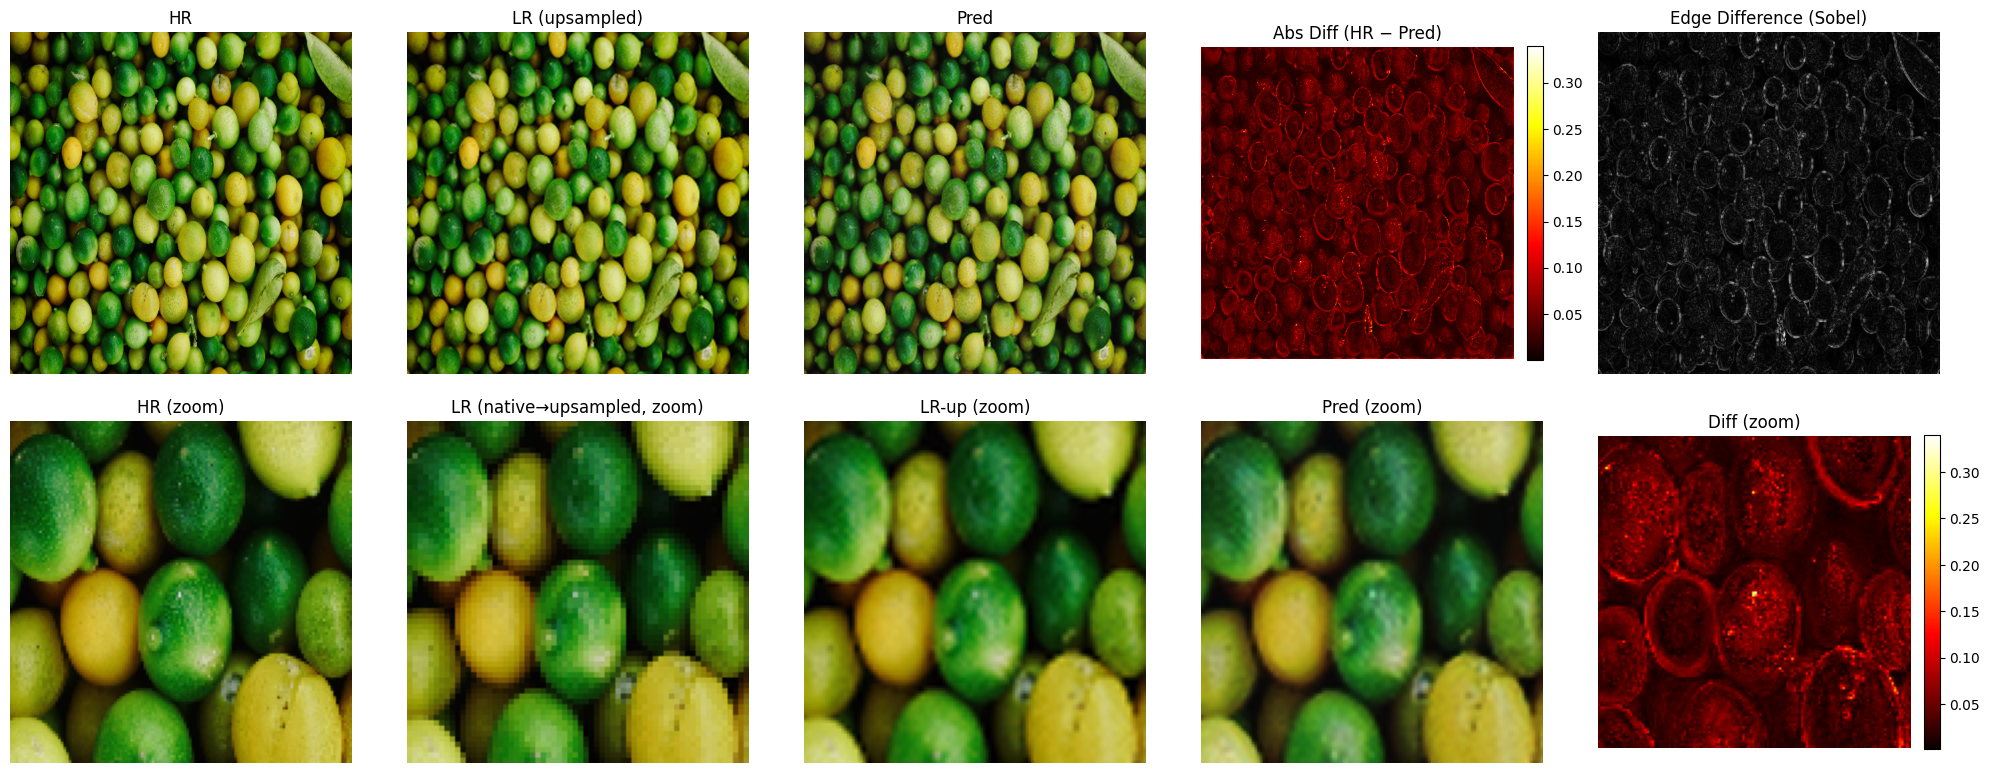

In [ ]:
# === OPTIONAL: VISUAL CHECK (enhanced) ===
import numpy as np
import matplotlib.pyplot as plt
import cv2

for lr, hr in valid_ds.take(1):
    pred = model.predict(lr, verbose=1)
    i = 1

    # Tensors -> np and basic prep
    hr_i   = hr[i].numpy()                        # (H, W, 3), float32 in [0,1]
    lr_i   = lr[i].numpy()                        # (h, w, 3), float32 in [0,1]
    pred_i = pred[i]                              # (H?, W?, 3), float32 (0..1-ish)

    # If output size differs from HR, resize prediction (and LR for fair side-by-side)
    H, W = hr_i.shape[:2]
    if pred_i.shape[:2] != (H, W):
        pred_i = cv2.resize(pred_i, (W, H), interpolation=cv2.INTER_CUBIC)
    if lr_i.shape[:2] != (H, W):
        lr_up = cv2.resize(lr_i, (W, H), interpolation=cv2.INTER_CUBIC)
    else:
        lr_up = lr_i

    # Clip to [0,1] for safe display
    hr_i   = np.clip(hr_i,   0, 1)
    lr_up  = np.clip(lr_up,  0, 1)
    pred_i = np.clip(pred_i, 0, 1)

    # --- 1) Absolute difference heatmap (HR vs Pred) ---
    diff = np.abs(hr_i - pred_i)                 # (H, W, 3)
    diff_gray = diff.mean(axis=2)                # (H, W)

    # --- 2) Auto-zoom around the largest error ---
    def crop_around(yx, size, H, W):
        cy, cx = yx
        hh = size // 2
        y1 = max(0, cy - hh); y2 = min(H, cy + hh)
        x1 = max(0, cx - hh); x2 = min(W, cx + hh)
        return slice(y1, y2), slice(x1, x2)

    maxy, maxx = np.unravel_index(np.argmax(diff_gray), diff_gray.shape)
    crop_size = min(128, min(H, W))  # reasonable default
    ys, xs = crop_around((maxy, maxx), crop_size, H, W)

    hr_crop   = hr_i[ys, xs]
    pred_crop = pred_i[ys, xs]
    diff_crop = diff_gray[ys, xs]

    # --- 2a) Corresponding LR crops (native and upsampled) ---
    # Map HR crop window to LR-native coordinates
    h_lr, w_lr = lr_i.shape[:2]
    sy = h_lr / float(H)
    sx = w_lr / float(W)

    lr_y1 = int(round(ys.start * sy)); lr_y2 = int(round(ys.stop * sy))
    lr_x1 = int(round(xs.start * sx)); lr_x2 = int(round(xs.stop * sx))

    # Keep indices in bounds and ensure at least 1 pixel
    lr_y1 = np.clip(lr_y1, 0, max(0, h_lr - 1))
    lr_y2 = np.clip(max(lr_y2, lr_y1 + 1), 1, h_lr)
    lr_x1 = np.clip(lr_x1, 0, max(0, w_lr - 1))
    lr_x2 = np.clip(max(lr_x2, lr_x1 + 1), 1, w_lr)

    lr_native_crop = lr_i[lr_y1:lr_y2, lr_x1:lr_x2]                   # native LR crop
    # Upsample native LR crop to the same display size as HR crop (to see blockiness)
    lr_native_crop_up = cv2.resize(
        lr_native_crop,
        (hr_crop.shape[1], hr_crop.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )
    # Also crop from the already upsampled LR image (same window as HR)
    lr_up_crop = lr_up[ys, xs]

    # --- 3) Edge maps (Sobel) + edge difference (full image) ---
    def to_gray_u8(x):
        g = (0.299*x[...,0] + 0.587*x[...,1] + 0.114*x[...,2])
        g = np.clip(g*255.0, 0, 255).astype(np.uint8)
        return g

    hr_g   = to_gray_u8(hr_i)
    pred_g = to_gray_u8(pred_i)

    sobelx_hr = cv2.Sobel(hr_g,   cv2.CV_32F, 1, 0, ksize=3)
    sobely_hr = cv2.Sobel(hr_g,   cv2.CV_32F, 0, 1, ksize=3)
    edges_hr  = np.hypot(sobelx_hr, sobely_hr)

    sobelx_pr = cv2.Sobel(pred_g, cv2.CV_32F, 1, 0, ksize=3)
    sobely_pr = cv2.Sobel(pred_g, cv2.CV_32F, 0, 1, ksize=3)
    edges_pr  = np.hypot(sobelx_pr, sobely_pr)

    edge_diff = np.abs(edges_hr - edges_pr)

    def norm01(x):
        x = x.astype(np.float32)
        m, M = np.min(x), np.max(x)
        return (x - m) / (M - m + 1e-8)

    edges_hr_n  = norm01(edges_hr)
    edges_pr_n  = norm01(edges_pr)
    edge_diff_n = norm01(edge_diff)

    # --- Plot grid ---
    # Row1: HR / LR-up / Pred / Abs Diff / Edge Diff (full image)
    # Row2: HR (zoom) / LR (native→upsampled, zoom) / LR-up (zoom) / Pred (zoom) / Diff (zoom)
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    axs[0,0].imshow(hr_i);     axs[0,0].set_title("HR");                 axs[0,0].axis("off")
    axs[0,1].imshow(lr_up);    axs[0,1].set_title("LR (upsampled)");     axs[0,1].axis("off")
    axs[0,2].imshow(pred_i);   axs[0,2].set_title("Pred");               axs[0,2].axis("off")
    im = axs[0,3].imshow(diff_gray, cmap="hot")
    axs[0,3].set_title("Abs Diff (HR − Pred)"); axs[0,3].axis("off")
    axs[0,4].imshow(edge_diff_n, cmap="gray")
    axs[0,4].set_title("Edge Difference (Sobel)"); axs[0,4].axis("off")

    axs[1,0].imshow(hr_crop);             axs[1,0].set_title("HR (zoom)");                    axs[1,0].axis("off")
    axs[1,1].imshow(lr_native_crop_up);   axs[1,1].set_title("LR (native→upsampled, zoom)");  axs[1,1].axis("off")
    axs[1,2].imshow(lr_up_crop);          axs[1,2].set_title("LR-up (zoom)");                 axs[1,2].axis("off")
    axs[1,3].imshow(pred_crop);           axs[1,3].set_title("Pred (zoom)");                  axs[1,3].axis("off")
    im2 = axs[1,4].imshow(diff_crop, cmap="hot")
    axs[1,4].set_title("Diff (zoom)");    axs[1,4].axis("off")

    # Colorbars for the two heatmaps
    cbar1 = fig.colorbar(im,  ax=axs[0,3], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1,4], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    break